In [150]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
from itertools import combinations

In [151]:
# How many particles we simulate
NUM_PARTICLES = 500
# Max particle starting speed in m/s
SPEED = 25
# Radius of a particle 
RADIUS = 0.01

In [152]:
# ID for each particle
ids = np.arange(NUM_PARTICLES)

# Initialise with random starting positions between 0 and 1
# startx = np.random.random(NUM_PARTICLES)
# starty = np.random.random(NUM_PARTICLES)
pos = np.random.random((2, NUM_PARTICLES))

# Initialise random starting velocities, between -SPEED and SPEED
# vx = (np.random.random(NUM_PARTICLES) - 0.5) * SPEED * 2
# vy = (np.random.random(NUM_PARTICLES) - 0.5) * SPEED * 2
vs = (np.random.random((2, NUM_PARTICLES)) - 0.5) * SPEED * 2


# Particles on the right will be coloured red, on the left will be blue
red = pos[0] > 0.5
blue = pos[0] <= 0.5

# PAIRS OF PARTICLES WE CAN CHECK FOR
pairs = np.asarray(list(combinations(ids, 2)))




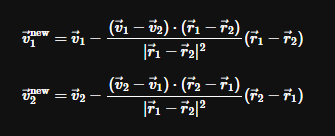

In [153]:
def show(pos, ax):
    cred = matplotlib.collections.PatchCollection(pos[...,red], facecolors = 'red')
    cblue = matplotlib.collections.PatchCollection(pos[...,blue], facecolors = 'blue')
    # ax.scatter(pos[0][red], pos[1][red], color='r', s=8)
    # ax.scatter(pos[0][blue], pos[1][blue], color='b', s=8)
    ax.add_collection(cred)
    ax.add_collection(cblue)
# plt.show()

In [154]:
def step(pos, v, touching=tuple(), dt=0.0001):
    pos = pos + v * dt
    # EDGE COLLISION

    
    v[0, pos[0] > 1] = -np.abs(v[0, pos[0] > 1])
    v[0, pos[0] < 0] = np.abs(v[0, pos[0] < 0])

    v[1, pos[1] > 1] = -np.abs(v[1, pos[1] > 1])
    v[1, pos[1] < 0] = np.abs(v[1, pos[1] < 0])
    
    # X AND Y DIFFERENCES IN POSITIONS OF EACH PAIR
    x_diffs = np.diff(pos[0,pairs]).T[0]
    check = x_diffs < 2*RADIUS # if two particles are already too far away in the x direction to collide, we don't need to check the y direction
    y_diffs = np.diff(pos[1,pairs[check]]).T[0]

    # Pairwise distances of particles which are close enough in the x direction
    dist_pairs = np.sqrt(x_diffs[check]**2 + y_diffs**2)
    # Distance = sqrt(delta_x^2 + delta_y^2)

    old_v = v.copy()

    # IDs of particles which are touching
    collision = pairs[check][dist_pairs < 2*RADIUS]

    v1 = v[:,collision[:,0]]
    v2 = v[:,collision[:,1]]
    r1 = pos[:,collision[:,0]]
    r2 = pos[:,collision[:,1]]

    v1new = v1 - ((v1-v2)*(r1-r2)).sum(axis=0) / np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - ((v1-v2)*(r1-r2)).sum(axis=0) / np.sum((r2-r1)**2, axis=0) * (r2-r1)

    
    
    v[:,collision[:,0]] = v1new
    v[:,collision[:,1]] = v2new

    # PARTICLES TOUCHING EACH OTHER IN PREVIOUS FRAME CANNOT COLLIDE IN NEXT FRAME
    if not (touching is tuple()):
        v[:,touching[:,0]] = old_v[:,touching[:,0]]
        v[:,touching[:,1]] = old_v[:,touching[:,1]]
    # print(check[collision])

    # pos[:,collision[:,0]] = pos[:,collision[:,0]] + v1new * dt
    # pos[:,collision[:,1]] = pos[:,collision[:,1]] + v2new * dt

    touching = collision.copy()
    return pos, v, touching


FRAMES = 1000

positions = np.zeros((FRAMES, 2, NUM_PARTICLES))
velocities = np.zeros((FRAMES, 2,NUM_PARTICLES))
touching = tuple()
for i in range(FRAMES):
    positions[i] = pos.copy()
    velocities[i] = vs.copy()
    pos, vs, touching = step(pos, vs, touching)

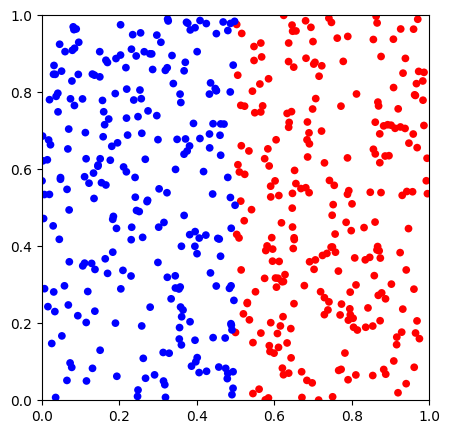

In [155]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
def animate(i):
    ax.clear()
    p = positions[i]
    redx, redy = p[0][red], p[1][red]
    bluex, bluey = p[0][blue], p[1][blue]

    red_circles = [plt.Circle((x,y), radius=RADIUS, linewidth=0) for x,y in zip(redx, redy)]
    blue_circles = [plt.Circle((x,y), radius=RADIUS, linewidth=0) for x,y in zip(bluex, bluey)]
    cred = matplotlib.collections.PatchCollection(red_circles, facecolors = 'red')
    cblue = matplotlib.collections.PatchCollection(blue_circles, facecolors = 'blue')

    ax.add_collection(cred)
    ax.add_collection(cblue)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

ani = animation.FuncAnimation(fig, animate, frames=500, interval=20)
ani.save('col_test5.gif', writer='pillow', fps=30, dpi=200)

In [156]:
tuple() is tuple()

True